
# Two alternative methods to traditional random forest feature selection
- A model is fitted on 60% of the whole dataset (These feature importances will serve as a benchmark for our methods) . The feature importances are stored it in a pickle file
- Extracting features using these alternative methods, we will compare it with traditional random forest feature selection method at the end

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

from matplotlib.pyplot import figure


Loading the samples

In [2]:
samples=[]
for i in range(0,6):
    filename=open('SampleNo.'+str(i),'rb')
    samples.append(pickle.load(filename)) 
    filename.close()

In [3]:
samples[0].head()

,0,Class,1,2,3,4,5,6,7,8,...,66635,66636,66637,66638,66639,66640,66641,66642,66643,66644
4807,0.219468,2,0.000000,0.000000,0.000000,0.000018,0.000000,0.000000,0.000000,0.000000,...,0.007770,0.005629,0.010226,0.010028,0.003931,0.003401,0.0,0.034420,0.000489,0.024073
909,0.094349,5,0.000497,0.000524,0.000097,0.000162,0.002755,0.065574,0.022222,0.001355,...,0.004538,0.005114,0.002429,0.003818,0.002409,0.000510,0.0,0.016304,0.000000,0.010176
7649,0.007298,1,0.000497,0.000524,0.000193,0.000036,0.002755,0.016393,0.005556,0.000000,...,0.005783,0.002042,0.007231,0.003416,0.002476,0.006943,0.0,0.041667,0.004618,0.015210
3903,0.053086,9,0.001490,0.001748,0.000870,0.000126,0.022039,0.131148,0.072222,0.013550,...,0.004058,0.001030,0.006124,0.000824,0.008390,0.003427,0.0,0.012681,0.000000,0.021337
5385,0.150254,3,0.002732,0.002273,0.001353,0.000198,0.022039,0.180328,0.072222,0.017615,...,0.000908,0.001679,0.001254,0.004803,0.001255,0.003452,0.0,0.021739,0.000000,0.004267


Initializing a two dictionaries where each key is feature number and value is 
1. the count of times it's feature importance is greater than one for all models
2. the sum of feature importances across all models

In [4]:
feature_count={}
featureimportances_sum={}

for i in range(0,66645):
    feature_count[str(i)]=0
    featureimportances_sum[str(i)]=0

For every sample:
*    Train Test Split
*    Use RandomizedSearchCV to find best parameters
*    Fit Random Forest Model on train data
*    Print logloss on train,cv and test data
*    Treating other samples as test data, print the log loss
*    For every value in feature importance
*        If feature importance is >0, Update the count in count dictionary, Add the feature importance for the feature importance sum dictionary

In [5]:
for x,dataset in enumerate(samples):
    #train test splitting
    print("----------------Sample No.",x+1,"----------------")
    result_y=dataset['Class']
    dataset=dataset.drop(['Class'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(dataset, result_y,stratify=result_y,test_size=0.20)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)
    
    #using Randomized Search to find best parameters
    clf=RandomForestClassifier()
    prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'min_samples_split':[2,3,4]
    }
    random_cfl=RandomizedSearchCV(clf,param_distributions=prams,n_jobs=-1)
    random_cfl.fit(X_train, y_train)
    
    print("Best Parameters: ",random_cfl.best_params_)
    
    #using best parameters and fitting a model on it
    clf=RandomForestClassifier(n_estimators=random_cfl.best_params_['n_estimators'],\
                               max_depth=random_cfl.best_params_['max_depth'],\
                               min_samples_split=random_cfl.best_params_['min_samples_split'])
    clf.fit(X_train,y_train)
    
    print("Train Logloss for model on sample no.",x+1,"is",log_loss(y_train,clf.predict_proba(X_train)))
    print("CV Logloss for model on sample no.",x+1,"is",log_loss(y_cv,clf.predict_proba(X_cv)))
    print("Test Logloss for model on sample no.",x+1,"is",log_loss(y_test,clf.predict_proba(X_test)),"\n")
    
    #Logloss on treating other samples as test data
    loglossonsamples=0
    for i in range(0,6):
        if x==i:
            continue
        loglossonsamples+=log_loss(samples[i]['Class'],clf.predict_proba(samples[i].drop(['Class'],axis=1)))
    loglossonsamples/=5
    print("Logloss on treating other samples as test data is: ",loglossonsamples,"\n")
    
    for i,j in enumerate(clf.feature_importances_):
        if j>0:
            feature_count[str(i)]+=j
            featureimportances_sum[str(i)]+=1

----------------Sample No. 1 ----------------
Best Parameters:  {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 10}
Train Logloss for model on sample no. 1 is 0.1529792351757313
CV Logloss for model on sample no. 1 is 0.5142102756899211
Test Logloss for model on sample no. 1 is 0.43239809254852296 

Logloss on treating other samples as test data is:  0.5439088937504292 

----------------Sample No. 2 ----------------
Best Parameters:  {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 5}
Train Logloss for model on sample no. 2 is 0.3886973953100319
CV Logloss for model on sample no. 2 is 0.636202952835223
Test Logloss for model on sample no. 2 is 0.6098734497248955 

Logloss on treating other samples as test data is:  0.6961036317033498 

----------------Sample No. 3 ----------------
Best Parameters:  {'n_estimators': 2000, 'min_samples_split': 2, 'max_depth': 10}
Train Logloss for model on sample no. 3 is 0.1574492535072459
CV Logloss for model on sample no. 3 is 0.5

Convert the dictionary to an array where index is feature number and value is count/feature importance sum

In [6]:
featureimportances_sum_array=np.zeros(66645)

for i in range(0,66645):
    featureimportances_sum_array[i]=featureimportances_sum[str(i)]
featureimportances_sum_array.sort()

In [7]:
feature_count_array=np.zeros(66645)

for i in range(0,66645):
    feature_count_array[i]=feature_count[str(i)]
feature_count_array.sort()

No. of features with Non-Zero feature importance: (This will be same for both count based and feature importance sum based methods)

In [8]:
len(np.nonzero(featureimportances_sum_array)[0])

23827

# Traditional way of Random Forest Feature Selection
- Fit a model onto a sample of data
- Select features on basis of feature importances

In [9]:
#As we already have 6 samples, let's fit model on one of the sample
dataset=samples[3]

result_y=dataset['Class']
dataset=dataset.drop(['Class'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(dataset, result_y,stratify=result_y,test_size=0.20)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)
    
clf=RandomForestClassifier()
clf.fit(X_train,y_train)

traditional_way_importance={}
for i,j in enumerate(clf.feature_importances_):
    traditional_way_importance[i]=j

Converting it to an array as well

In [10]:
traditional_way_importance_array=np.zeros(66645)

for i in range(0,66645):
    traditional_way_importance_array[i]=traditional_way_importance[i]
traditional_way_importance_array.sort()

In [11]:
len(np.nonzero(traditional_way_importance_array)[0])

1299

# Real Feature Importances
- Obtained by fitting model onto 60% of whole dataset

In [12]:
#loading the real feature importances
realfeatureimportances=pickle.load(open("featureimportances",'rb'))

In [13]:
realfeatureimportances_array=np.zeros(66645)
for i in range(0,66645):
    realfeatureimportances_array[i]=realfeatureimportances[i]
realfeatureimportances_array.sort()

In [14]:
len(np.nonzero(realfeatureimportances_array)[0])

19882

# Comparison

## How many of the features with importance more than zero are really important?
i.e their feature importance is non-zero in real model fitted onto the dataset as well

In [15]:
correct=0
for i in realfeatureimportances:
    if featureimportances_sum[str(i)]>0:
        if realfeatureimportances[i]>0:
            correct+=1
print(correct,"features from our samples are present in the real model")

8640 features from our samples are present in the real model


In [16]:
correct=0
for i in realfeatureimportances:
    if traditional_way_importance[i]>0:
        if realfeatureimportances[i]>0:
            correct+=1
print(correct,"features from samples in traditional way are present in the real model")

708 features from samples in traditional way are present in the real model


## Comparison of top n features
- How many of the top n features are present in top n features of real model?

In [17]:
topnfeatures=[250,500,1000,5000,10000]

### Summation of feature importances

In [18]:
correct=np.zeros(5)
for i in realfeatureimportances:
    for k,j in enumerate(topnfeatures):
        if realfeatureimportances[i]>=realfeatureimportances_array[-1*j]:
            if featureimportances_sum[str(i)]>featureimportances_sum_array[-1*j]:
                correct[k]+=1
for i,j in enumerate(topnfeatures):
    print("No. of features selected by this method in top",j,"features of real model: ",correct[i])
summationoffeatureimportances=correct

No. of features selected by this method in top 250 features of real model:  30.0
No. of features selected by this method in top 500 features of real model:  141.0
No. of features selected by this method in top 1000 features of real model:  438.0
No. of features selected by this method in top 5000 features of real model:  2027.0
No. of features selected by this method in top 10000 features of real model:  2403.0


### Count based

In [19]:
correct=np.zeros(5)
for i in realfeatureimportances:
    for k,j in enumerate(topnfeatures):
        if realfeatureimportances[i]>=realfeatureimportances_array[-1*j]:
            if feature_count[str(i)]>feature_count_array[-1*j]:
                correct[k]+=1
for i,j in enumerate(topnfeatures):
    print("No. of features selected by this method in top",j,"features of real model: ",correct[i])
countbasedfeatureimportance=correct

No. of features selected by this method in top 250 features of real model:  94.0
No. of features selected by this method in top 500 features of real model:  227.0
No. of features selected by this method in top 1000 features of real model:  512.0
No. of features selected by this method in top 5000 features of real model:  1993.0
No. of features selected by this method in top 10000 features of real model:  3345.0


### Traditional way

In [20]:
correct=np.zeros(5)
for i in realfeatureimportances:
    for k,j in enumerate(topnfeatures):
        if realfeatureimportances[i]>=realfeatureimportances_array[-1*j]:
            if traditional_way_importance[i]>traditional_way_importance_array[-1*j]:
                correct[k]+=1
for i,j in enumerate(topnfeatures):
    print("No. of features selected by this method in top",j,"features of real model: ",correct[i])
traditionalwayfeatureimportance=correct

No. of features selected by this method in top 250 features of real model:  38.0
No. of features selected by this method in top 500 features of real model:  105.0
No. of features selected by this method in top 1000 features of real model:  226.0
No. of features selected by this method in top 5000 features of real model:  469.0
No. of features selected by this method in top 10000 features of real model:  563.0


# Visualizing the comparison

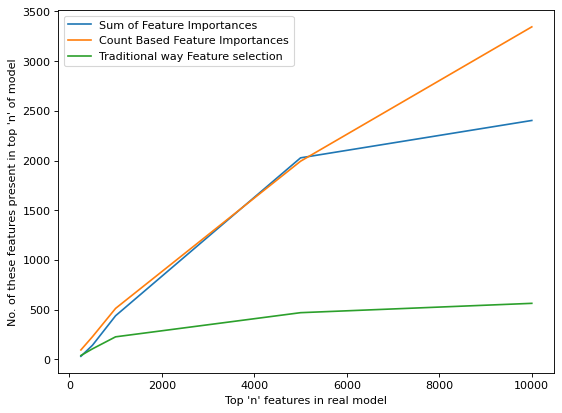

In [21]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(topnfeatures,summationoffeatureimportances)
plt.plot(topnfeatures,countbasedfeatureimportance)
plt.plot(topnfeatures,traditionalwayfeatureimportance)
plt.legend(["Sum of Feature Importances","Count Based Feature Importances","Traditional way Feature selection"])
plt.xlabel("Top 'n' features in real model")
plt.ylabel("No. of these features present in top 'n' of model")
plt.show()